In [1]:
import pyro
import pyro.distributions as dist
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from probability_on_trial.weight import weight, expected_weight, normalize_sample



In [17]:
strength = 5
discretization = 100
# evidence if both original and new witnesses pull in two directions
# suppose witnesses have equal weight, contributing k to the "virtual sample size"

# def get_beta_weight(a, b, virtual_max = 10e5):
#     beta = dist.Beta(a, b)
#     uniform = dist.Beta(1, 1)
#     uniform_entropy = uniform.entropy()
#     informed = dist.Beta(a, virtual_max)
#     informed_entropy = informed.entropy()
#     entropy = beta.entropy()
#     normalized_entropy = (entropy - informed_entropy)/(uniform_entropy - informed_entropy)
#     weight = 1 - normalized_entropy
#     return weight

# weight_uniform = get_beta_weight(1, 1)
# weight_two = get_beta_weight(strength + 1, strength + 1)
# weight_four = get_beta_weight((strength + 1) * 2, (strength + 1) * 2)


# print(f"Weight of uniform distribution: {weight_uniform.item()}")
# print(f"Weight of two disagreeing distributions: {weight_two.item()}")
# print(f"Weight of four disagreeing distributions: {weight_four.item()}")

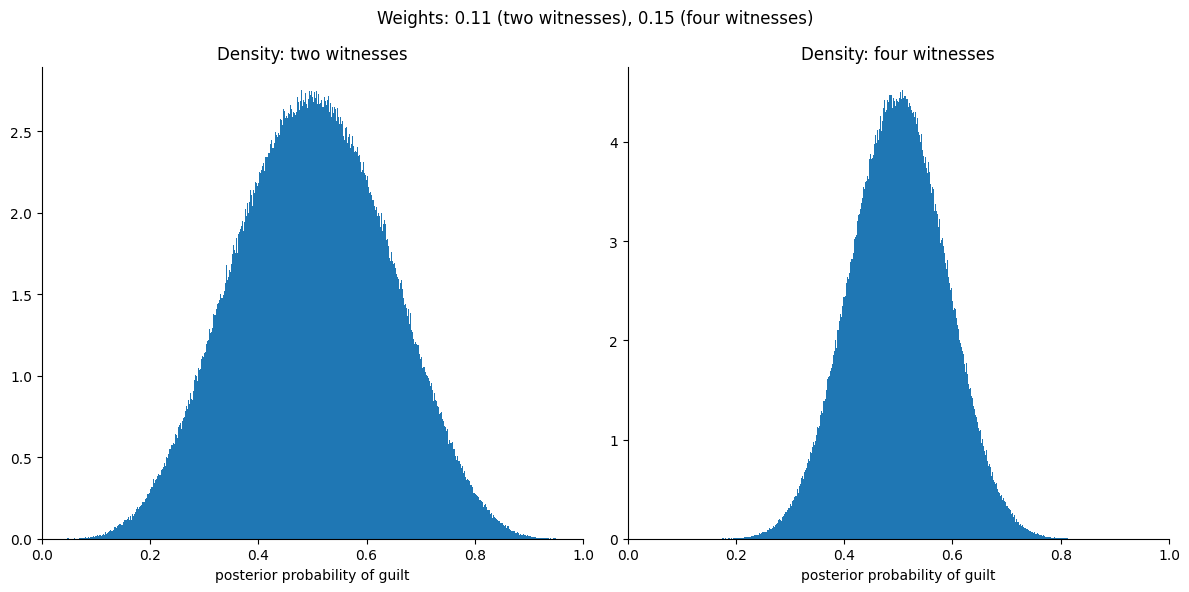

In [21]:
with pyro.plate("sample", 1e6):
    sample_two_witnesses = pyro.sample("sample_two_witnesses", dist.Beta((1+strength),(1+strength)))
    sample_four_witnesses = pyro.sample("sample_four_witnesses", dist.Beta((1 + (3 * strength)),(1 + (3 * strength))))
probabilities_two_witnesses = normalize_sample(sample_two_witnesses, k = discretization)
probabilities_four_witnesses = normalize_sample(sample_four_witnesses, k = discretization)

weight_two = weight(probabilities_two_witnesses)
weight_four = weight(probabilities_four_witnesses)


fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

ax = ax.flatten()

ax[0].set_title("Density: two witnesses")
ax[0].hist(sample_two_witnesses.numpy(), bins=500, density=True)
ax[0].set_xlabel("posterior probability of guilt")
ax[0].set_xlim(0,1)

ax[1].set_title("Density: four witnesses")
ax[1].hist(sample_four_witnesses.numpy(), bins=500, density=True)
ax[1].set_xlabel("posterior probability of guilt")


plt.suptitle(f"Weights: {weight_two:.2f} (two witnesses), {weight_four:.2f} (four witnesses)")

plt.tight_layout()
sns.despine()
plt.show()


# save figure
fig.savefig("figures/uncertainties_two_four_witnesses.pdf")


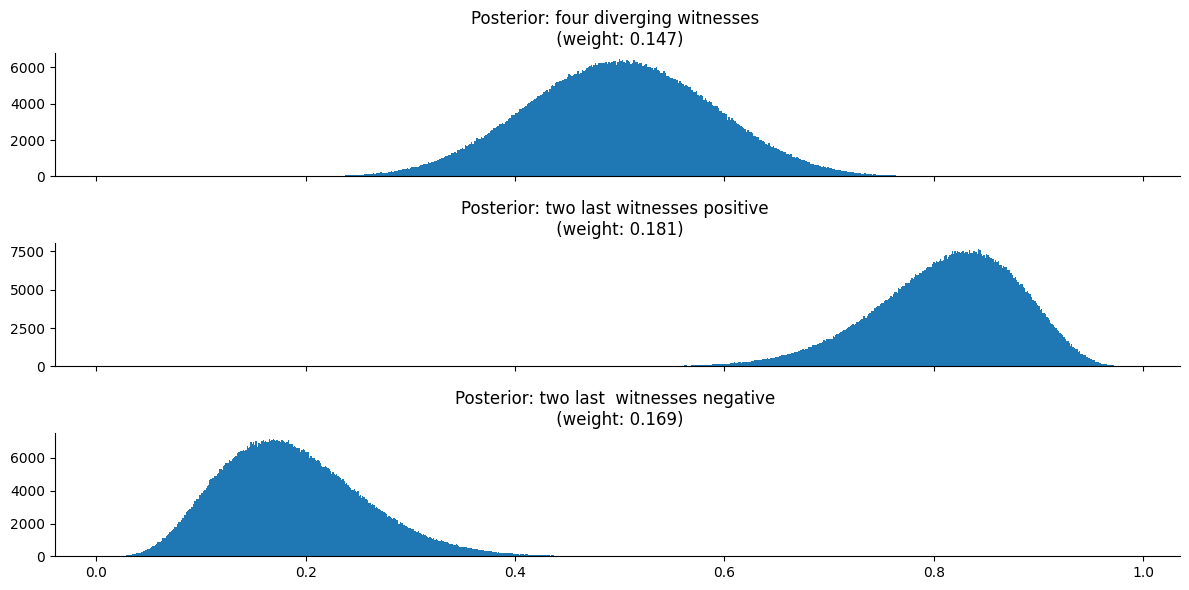

<Figure size 640x480 with 0 Axes>

In [ ]:
# now posteriors for three evidential scenarios

with pyro.plate("samples", 1e6):
#    prior = pyro.sample("prior", dist.Beta(1,1))

    sample_diverging = pyro.sample("sample_four_witnesses", dist.Beta((1 + (3 * strength)),(1 + (3 * strength))))
    sample_positive = pyro.sample("sample_positive", dist.Beta((1 + (5 * strength)),(1 + (1 * strength))))
    sample_negative = pyro.sample("sample_negative", dist.Beta((1 + (1 * strength)),(1 + (5 * strength))))

probabilities_diverging = normalize_sample(sample_diverging, k = discretization)
probabilities_positive = normalize_sample(sample_positive, k = discretization)
probabilities_negative = normalize_sample(sample_negative, k = discretization)

weight_diverging = weight(probabilities_diverging)
weight_positive = weight(probabilities_positive)
weight_negative = weight(probabilities_negative)


# weight_diverging = get_beta_weight((1 + (2 * strength)),(1 + (2 * strength)))
# weight_positive = get_beta_weight((1 + (3 * strength)),(1 + (1 * strength)))
# weight_negative = get_beta_weight((1 + (1 * strength)),(1 + (3 * strength)))

# print(weight_diverging, weight_positive, weight_negative)



In [29]:
# what are probs of evidence after two witnesses?
# suppose you use probability of guilt on which your posterior after two witnesses is centered

#P(E) = P(E|G)P(G) + P(E|~G)P(~G)

#suppose further that P(E = 1 |G) = 0.9 and P(E = 1|~G) = 0.1 for each item of evidence

def prob_of_evidence(lik0,lik1, prior, evidence):
    Hliks = [1-lik1, lik1]
    NHliks = [1-lik0, lik0]
    likelihood = Hliks[evidence] 
    Nlikelihood = NHliks[evidence]
    evidence = likelihood * prior + Nlikelihood * (1-prior)

    return evidence
    
#prob of witness "for"
for_prob = prob_of_evidence(0.1, 0.9, 0.5, 1)
against_prob = prob_of_evidence(0.1, 0.9, 0.5, 0)
print(for_prob, against_prob)

# suppose witnesses are independent, we have four scenarios: 11, 01, 10, 00
# probabilities of these scenarios are given by the product of the probabilities of each witness
probabilities_of_evidential_scenarios = torch.tensor([0.5*0.5, 0.5*0.5, 0.5*0.5, 0.5*0.5])
assert probabilities_of_evidential_scenarios.sum() == 1

print("Probabilities of evidential scenarios", probabilities_of_evidential_scenarios)

#weights are as specified above:
weights = torch.tensor([weight_positive, weight_diverging, weight_diverging, weight_negative,])

print(weight_two)

weight_changes = weights - weight_two
print(weights)
print(weight_changes)
expected_weight = (probabilities_of_evidential_scenarios * weight_changes).sum()
print(expected_weight)

0.5 0.5
Probabilities of evidential scenarios tensor([0.2500, 0.2500, 0.2500, 0.2500])
tensor(0.1091)
tensor([0.1805, 0.1468, 0.1468, 0.1689])
tensor([0.0714, 0.0377, 0.0377, 0.0598])
tensor(0.0517)


In [35]:
# rounding

previous_weight = torch.tensor(.11)
weights_post = torch.tensor([0.175, 0.15, 0.175])
probs = torch.tensor([0.25, .5, .25])

weight_changes = weights_post - previous_weight
print(weight_changes)
expected_weight_change = (probs * weight_changes).sum()

print(expected_weight_change)

tensor([0.0650, 0.0400, 0.0650])
tensor(0.0525)


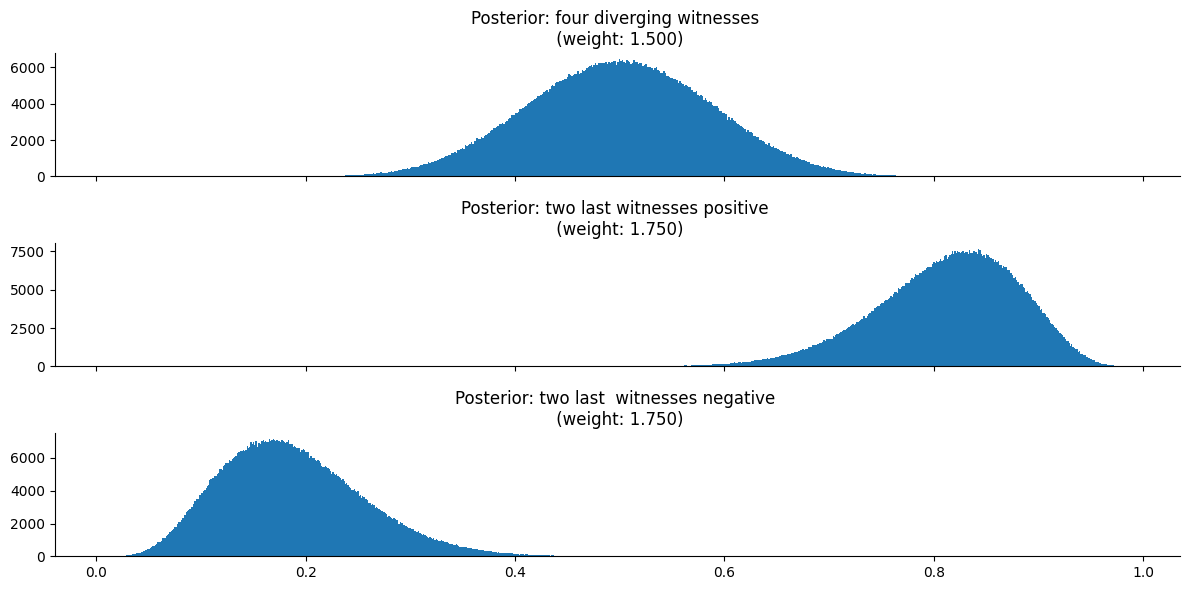

In [36]:
fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
ax = ax.flatten()

ax[0].set_title(f"Posterior: four diverging witnesses \n (weight: {1.5:.3f})")
ax[0].hist(sample_diverging, bins = 500)

ax[1].set_title(f"Posterior: two last witnesses positive \n (weight: {1.75:.3f})")
ax[1].hist(sample_positive, bins = 500)

ax[2].set_title(f"Posterior: two last  witnesses negative \n (weight: {1.75:.3f})")
ax[2].hist(sample_negative, bins = 500)

plt.tight_layout()
sns.despine()

plt.savefig("figures/four_witnesses_three_scenarios.pdf")
plt.show()
